# Text as data - Assignment 2 notebook
| Student | Matrikelnr. |
| ------- | ----------- |
|Julian Kath | 219386 |

In [35]:
import pandas as pd
import numpy as np
from bertopic import BERTopic
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import seaborn as sns
from sentence_transformers import SentenceTransformer
from transformers import AutoModel
import requests
import os
import umap
import umap.plot
import hdbscan
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import CategoricalColorMapper, HoverTool, ColumnDataSource
from bokeh.palettes import Colorblind
from utils.manifesto_api import query_manifesto
output_notebook()

Loading BokehJS ...

## Querying data from the Manifesto Project API

I actually retrieved all the data prior to creating this notebook, this is why I will not repeat that process in the notebook but only demonstrate that my code for retrieving information works. As the API does not allow bulk downloads (to my knowledge), I retrieved the meta data as-is, subsetted the neccessary id information from the dataset and then joined that data to the metadata, to get additional information. I did this for all english manifestos and separately for all manifestos from Germany (post-unification). 

In [ ]:
query_manifesto('texts_and_annotations', f'keys[]={c}', 'version=2022-1')

In [2]:
data_final = pd.read_csv('data\\manifestos_ger.csv')

data_final.cmp_code = pd.to_numeric(data_final.cmp_code, errors='coerce').astype(np.int64, errors='ignore')
data_final.partyabbrev = [p if p not in ['LINKE', 'L-PDS', 'PDS'] else 'LINKE' for p in data_final.partyabbrev]
data_final.edate = pd.to_datetime(data_final.edate)
data_final['year'] = data_final.edate.dt.year


data_env = data_final[(data_final.cmp_code == 501) & ~(data_final.partyname.isin(['Pirates', 'South Schleswig Votersâ Union']))]
data_env['half_decade'] = data_env.year//5*5
data_env['decade'] = data_env.year//10*10

conds = np.r_[np.NINF, np.linspace(10, 90, 9), 95, 98, np.inf]
choice = ['ECO', 'LEF', 'SOC', 'LIB', 'CHR', 'CON', 'NAT', 'AGR', 'ETH', 'SIP', 'DIV', 'MI']

data_env['partyfam'] = pd.cut(data_env.parfam, bins=conds, labels=choice)

plt_dt = (data_env
 .groupby(['year', 'partyabbrev'])
 .agg({'cmp_code': 'count'})
 .reset_index()
)

c:\Users\julia\OneDrive\Documents\GitHub\tad_assignment2\tad2_env\lib\site-packages\IPython\core\interactiveshell.py:3553: DtypeWarning: Columns (192) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


I settled on a dataset of German party manifestos. The dataset includes six parties: The Greens, CDU/CSU, FDP, die Linke, SPD and AfD. I removed Piraten and Südschleßischer Wählerverband (SSW) because they do not substantially affect the German public discourse on environment protection, as they are small and rather negligable parties. I also transformed the parties that die Linke merged from pre-2007 and included it as die Linke.

The dataset covers German party manifestos from 1998 onwards. In this period, there were 7 elections (which coincides with election manifestos) in 4 year intervals (with one 3 year interval between 2002 and 2005, due to Gerhard Schrörder's lost vote of no confidence which resulted in a shorter legislative period). For my research question, I am only focusing on those parts of the manifestos that refer to environment protection (code 501). The dataframe includes 4178 texts and 4148 unique texts. There are some duplicates, as either the policy demand in the manifesto did not change, or the line is very short, such as 'Klimaschutz' or 'Klimawandel'. The data is heavily skewed toward the manifestos of the Greeens which make almost half (48.7%) of all documents. The remaining parties account for between 10% to 15% of the documents, with AfD as an exception, making up only 1.2% (this is equivalent to 54 documents) and being present for only 2017 and 2021 (the party was only fonuded in 2013 and joined the Bundestag in 2017). Given the Green's programmatic/ ideologic focus their overrepresentation is to be expected. 

In general, there is a quite substantial increase in the number of documents over time, tripling from 6152 in 1998 to 18459 2021 (part of which can be accounted for by the increase in the number of parties). However, this could also exhibit the transition of party politics determined by traditional electoral milieus (like SPD -> workers' party) to a competition for the political center. Taking the mean number of texts per party, there is still a substantial increase from ~1200 to ~2600 documents. With regards to the filtered dataset (filtering out parties & subsetting environment protection coded documents) a slightly different trend exists, with 48 documents per party in 1998, 143 in 2021, and a peak of 209 in 2013, mostly driven by an increase of documents by the Greens' election manifesto.

<AxesSubplot:xlabel='partyabbrev', ylabel='cmp_code'>

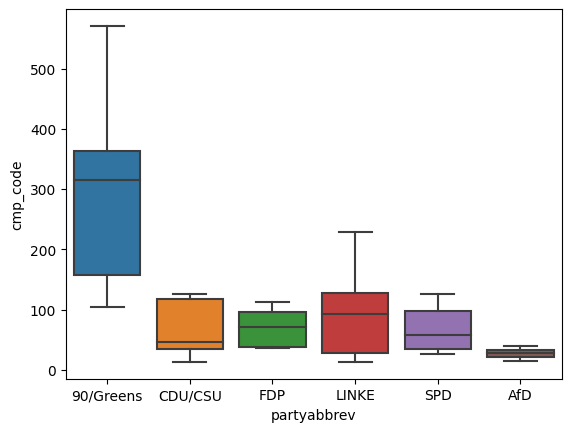

In [3]:
sns.boxplot(data=plt_dt, x='partyabbrev', y='cmp_code')

<AxesSubplot:xlabel='year', ylabel='cmp_code'>

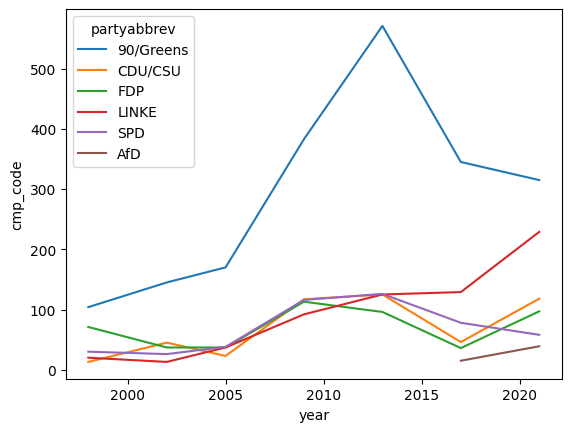

In [4]:
sns.lineplot(data=plt_dt, x='year', y='cmp_code', hue='partyabbrev')

## Research Question and Methodology

I will display the document feature matrix a little bit later, as it better fits into the workflow for my model choice, as I would like to employ [BERTopic](https://arxiv.org/pdf/2203.05794.pdf) to create the topic modelling. BERTopic does not actually compute a document-term matrix but rather implements a cluster-term frequency matrix, with dimensionality reduction and clustering steps in between (those will be described and analysed further below). I will create that cluster-term matrix further below, however with BERTopic there are a couple of additional steps before that is possible.

**My research question for this assignment is how policy demands on environment protection formulated in German party manifestos have changed since 1998. I will further explore whether shifts in formulations coincide with contextual events affecting environment protection policy.**

My research question is motivated by a number of factors. First, there is a practical reason: 
- While the manifesto project's codebook delivers very finegrained topics with regards to some policy areas, enivormental policy is not disaggregated meanigfully. This stands in stark contrast to the importance of the policy field as well as the multitude of dimensions to environment protection. Extracting topics from coded environment protection excerpts can possibly structure this into further policy sub fields.
- From a research perspective, I think it is interesting to see how the discourse on environment protection has changed over this timeframe (more than 2 decades), and which topics lost and gained importance.
- Finally, I would also like to see how BERTopic performs on such a task and check whether the architecture can create meaningful topics.

In theory, BERTopic should be very good for this task. As the annotated dataset is basically coded into single political demands, it is to be expected that there is not too much topic heterogeneity within the documents, which makes it ideal for the application of BERTopic.

With regards to unsupervised machine learning techniques such as topic modelling, it is quite dfficult to assess the validity/ robustness of the topics. This is why I iteratively employed different models and assessed their results with respect to creating meaningful topics, in the end, I settled with the current model setup. BERTopic allows to use different word embeddings. Depending on which language model is used for the calculations of the embeddings, the modelled topics will differ quite substantially. There are multiple other parameters, for instance when it comes to the dimensionality reduction and in particular the subsequent clustering, which could further be adjusted.

I actually tried out a few different models but only included 2 in this notebook. First, I am using the [standard stentence-transformers multilanguage model](https://huggingface.co/sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2). Then, I am using a [smaller sentence-transformers multilanguage model](https://huggingface.co/sentence-transformers/distiluse-base-multilingual-cased-v2) that I then train on the data.

In [72]:
vectorizer_model = CountVectorizer(stop_words=stopwords.words('german'))
german_model = BERTopic(verbose=True, vectorizer_model=vectorizer_model, language='german', min_topic_size=15)

Some weights of the model checkpoint at chkla/parlbert-topic-german were not used when initializing BertModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [211]:
from sentence_transformers import SentenceTransformer
sentence_model = SentenceTransformer("distiluse-base-multilingual-cased-v2")
embeddings = sentence_model.encode(data_env.text.to_list(), show_progress_bar=False)

loading configuration file C:\Users\julia/.cache\torch\sentence_transformers\sentence-transformers_distiluse-base-multilingual-cased-v2\config.json
Model config DistilBertConfig {
  "_name_or_path": "C:\\Users\\julia/.cache\\torch\\sentence_transformers\\sentence-transformers_distiluse-base-multilingual-cased-v2\\",
  "activation": "gelu",
  "architectures": [
    "DistilBertModel"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_hidden_states": true,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.24.0",
  "vocab_size": 119547
}

loading weights file C:\Users\julia/.cache\torch\sentence_transformers\sentence-transformers_distiluse-base-multilingual-cased-v2\pytorch_model.bin
All mod

In [212]:
tuned_model = BERTopic()
tuned_model.fit(data_env.text.to_list(), embeddings)

2022-11-18 02:50:14,987 - BERTopic - Reduced dimensionality
2022-11-18 02:50:15,218 - BERTopic - Clustered reduced embeddings


In [74]:
german_model.fit(data_env.text.to_list())

Batches: 100%|██████████| 131/131 [00:54<00:00,  2.41it/s]
2022-11-18 00:13:48,181 - BERTopic - Transformed documents to Embeddings
2022-11-18 00:13:54,259 - BERTopic - Reduced dimensionality
2022-11-18 00:13:54,451 - BERTopic - Clustered reduced embeddings


In [32]:
german_embeds = german_model._extract_embeddings(data_env.text.to_list())

The clustering process is facilitated by a dimensionality reduction step via UMAP. The reduced embeddings are then clustered with HDBSCAN. While traditional Topic modelling techniques employ TF-IDF, which combines two statistic measures, the term frequency and the inverse document frequency. BERTopic modifies this to a cluster-based TF-IDF score, that concetanates documents per cluster into a single cluster and 

In [183]:
def visualize_embeddings(german_embeds, german_model):

    umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine').fit_transform(german_embeds)
    
    result = pd.DataFrame(umap_data, columns=['x', 'y'])
    
    labels = [german_model.topic_mapper_.get_mappings()[i] for i in german_model.hdbscan_model.labels_]
    result['labels'] = [german_model.topic_labels_[i] for i in labels]

    datasource = ColumnDataSource(
        data=dict(
            x=result['x'].to_list(),
            y=result['y'].to_list(),
            text=data_env['text'].to_list(),
            party=data_env['partyabbrev'].to_list(),
            cluster=result['labels'].to_list()
        )
    )
    
    color_dict = {
        '90/Greens' : 'green',
        'LINKE' : 'blueviolet',
        'SPD' : 'red',
        'FDP' : 'yellow',
        'CDU/CSU' : 'black',
        'AfD' : 'blue'
    }
    
    color_mapping = CategoricalColorMapper(
        palette=list(color_dict.values()),
        factors=list(color_dict.keys())
    )
    
    tooltips = [
        ('Party', "@party"),
        ('Text', "@text"),
        ('Cluster', '@cluster')
    ]
    
    plot_figure = figure(
        title="UMAP Projection of German party manifestos' environment protection demands",
        plot_width=800, 
        plot_height=600,
        tools=('pan, wheel_zoom, reset, hover'),
        tooltips=tooltips
    )
    
    plot_figure.circle(
        'x', 'y', source=datasource,
        fill_color=dict(field='party', transform=color_mapping),
        line_color="grey", line_alpha=0.6, fill_alpha=0.6, size=4
    )

    return plot_figure

In [184]:
p1 = visualize_embeddings(german_embeds, german_model)

In [186]:
show(p1)

In [213]:
p2 = visualize_embeddings(embeddings, tuned_model)
show(p2)

At first glance, the cluster appear much clearer on the simple german embeddings. This is quite surprising, but could just have to do with the compression to only two components. Anyhow, to create the cluster-feature matrix however, I will employ the embeddings from the non-finetuned model. 

In [59]:
umap_embed = umap.UMAP(n_neighbors=15, n_components=5, 
                       min_dist=0.0, metric='cosine').fit_transform(german_embeds)
    
clusters = hdbscan.HDBSCAN(min_cluster_size=15,
                           metric='euclidean',
                           cluster_selection_method='eom').fit(umap_embed)

docs_df = pd.DataFrame(data_env, columns=['text'])
docs_df['Topic'] = clusters.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_cluster = docs_df.groupby(['Topic'], as_index=False).agg({'text': ' '.join})

In [60]:
def c_tf_idf(docs, m):
    count = CountVectorizer(stop_words=stopwords.words('german')).fit(docs)
    t = count.transform(docs).toarray()
    tf = np.divide(t.T, t.sum(axis=1))
    idf = np.log(np.divide(m, t.sum(axis=0))).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)
    
    return tf_idf, count

tf_idf, count = c_tf_idf(docs_per_cluster.text.values, m=len(data_env))

As dicussed above, there is no actual term-document matrix in BERTopic, but rather a term-cluster matrix. The resulting matrix has 47 clusters (which we already saw in the plot above, visualized in 2D) with 9207 words (after excluding German stopwords)). 

In [61]:
pd.DataFrame(tf_idf.T, columns=count.get_feature_names_out())

,00,000,06,09,10,100,107,11,110,113,...,überwachung,überwachungsbedürftigen,überwiegend,überwinden,überwunden,überzeugen,überzeugt,überzeugung,übliche,übrigen
0,0.001573,0.003613,0.000858,0.000000,0.001347,0.003398,0.000000,0.000000,0.000858,0.000000,...,0.001573,0.000000,0.000787,0.001573,0.000858,0.001573,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.005968,0.000000,0.000000,0.000000,0.005472,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.005968
3,0.000000,0.000000,0.000000,0.000000,0.017885,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013426,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.024268,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.020616,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Topic models & model choices

Topic modeling is an unsupervised machine learning technique that’s capable of scanning a set of documents, detecting word and phrase patterns within them. It automatically clusters word groups and similar expressions that best characterize a set of documents. 

Word embeddings represent words as vectors (lists of numbers). Large language models, such as BERT can not only represent simple words in vectors, but an entire sentence, through a model architecture called transformers. Transformers are Recurrent Neural Networks employing a method called attention. Attention essentially ensures that the context of the words is evaluated in their embedding representation.

These embeddings are then finetuned on different texts. In general in 

In [120]:
german_model.get_topic_info()[1:12]

,Topic,Count,Name
1,0,247,0_tierschutz_tiere_tierhaltung_tieren
2,1,172,1_atomausstieg_atomkraft_atomkraftwerke_kernen...
3,2,161,2_deutschland_deutschen_deutsche_deutschlands
4,3,157,3_mobilität_bahn_schiene_verkehr
5,4,130,4_klimaschutz_klima_klimagerechtigkeit_klimane...
6,5,123,5_pestiziden_reduzieren_einsatz_feinstaub
7,6,118,6_co2_emissionshandel_emissionen_treibhausgase
8,7,95,7_abfällen_recycling_wiederverwendung_abfälle
9,8,91,8_umweltschutz_umwelt_umweltpolitik_politik
10,9,90,9_flüsse_wasserrahmenrichtlinie_gewässer_hochw...


When checking the texts that were clustered to the 47 clusters, it is quite interesting to check in the plot above which texts they represent. All unassigned texts are assigned to topic -1, which is therefore naturally counting the most documents. 

## Topics over time

To create the topics over time, the fitted model needs to be compared with the vector representation at each year subset of the data. From the fitted models, the c-TF-IDF representations are therefore calculate at each timestamp. Then, the c-TF-IDF representations at each timestamp are averaged with the global c-TF-IDF representations in order to fine-tune the local representations. This results in slightly different representations of the global model's topics. Further, I also chose to not average each topic representation at timestamp t with the global c-TF-IDF matrix. This prevents words from the global word embeddings to leak into the topic representations at each timestamp.

In [82]:
topics_over_time = german_model.topics_over_time(data_env.text.to_list(), 
                                                data_env.year.to_list(),
                                                evolution_tuning=True,
                                                global_tuning=False)
german_model.visualize_topics_over_time(topics_over_time, top_n_topics=12)

7it [00:00, 19.10it/s]


In [115]:
for i in range(0, 12):
    print(f"Topic: {german_model.get_topic_info()[1:13].iloc[i, 2]}")
    print(german_model.get_representative_docs(i))
    print("________________________________")

Topic: 0_tierschutz_tiere_tierhaltung_tieren
['und für mehr Tier-und Umweltschutz.', '-\xa0\xa0 eine artgerechte Tierhaltung und -ernährung sowie deren effektive Kontrolle.', 'Wir wollen eine Tierhaltung, die flächengebunden und auf die einheimische Nachfrage bezogen ist.']
________________________________
Topic: 1_atomausstieg_atomkraft_atomkraftwerke_kernenergie
['Bis zur bestmöglichen Endlagerung braucht der Atommüll die bestmögliche Zwischenlagerung.', 'Wir wollten aus der Atomkraft aussteigen, als noch alle Mächtigen Atomfans waren.', '• … bekommt den Atomausstieg und die schnellstmögliche Stilllegung aller Atomreaktoren.']
________________________________
Topic: 2_deutschland_deutschen_deutsche_deutschlands
['Wir wollen die Qualität der deutschen Gewässer weiter verbessern.', 'Der Schutz der Natur ist auch ein wichtiger Impuls für den sich langsam entwickelnden naturnahen Tourismus in den ländlichen Regionen Ostdeutschlands.', 'Mit ihren vielen Großschutzgebieten, zum Beispiel me

## Discussion of results


The dynamic topic model shows that enviornment protection is clustered into animal rights, nuclear energy, a general topic representing appeals to the nation, 'Germany', another topic on mobility (and specifically trains), a further topic on climate change and climate protection, a topic on the reduction of pesticides and fine dust. Emissions and emission trading also was clustered as a topic, as did recycling, and enivornment protection (quite probably in the sense of ecological protection). Finally, there is also topics on water protection, forrest protection and forrestry, and nature conservation. In total, these topics seems like a very good modelling of the different sub topics of environment protection.

The evolvement of the topics over time shows some quite interesting trends:
- for instance that nuclear energy increased until 2013, but then decreased afterwards, which makes a lot of sense, as Germany officially announced to quit nuclear energy in 2012.
- Another interesting trend is that the nationality topic which associated many different environment sub-fields with nationalism is decreaseing *after* the AfD enters the political stage.
- The results also document how climate protection became an utterly central topic from 2017 to 2021. While this makes sense, it is is still surprising to see, how erratic this trend goes up.
- The most prominent topic is - somewhat surprisingly - animal protection. I could imagine that this is due to the fact that the parties all refer to animals in their manifestos but mean very different things when talking about animal rights 

In [219]:
german_model.visualize_heatmap(n_clusters=5, top_n_topics=20, width=1000, height=1000)

When clustering the different topics it seems as though that many of the ecological topics such as nature conservation, pesticide prohibition, water protection, species protection and so on appear to be clustered together, with a high similarity score.

In [218]:
german_model.visualize_barchart(custom_labels=False, top_n_topics=12)

In [70]:
topics_per_class = german_model.topics_per_class(data_env.text, classes=data_env.partyabbrev)
german_model.visualize_topics_per_class(topics_per_class, top_n_topics=12)

6it [00:00, 18.23it/s]


Comparing the topics by party, there is interesting observations:
- The conservative and extreme-right parties appeal relatively often to forrests and Germany. This is reversed for the Greens and the left parties.
- The topic "Klimaschutz" is completely absent from the AfD
- The Naturschutz topic seems pretty absent from the FDP. At the same time, the party appeals to the energetic renovation of buildings